# sell-in-may-and-go-away

see: https://en.wikipedia.org/wiki/Sell_in_May

"Sell in May and go away" (aka the Halloween indicator) is an investment adage warning investors to divest their stock holdings in May and wait to reinvest in November.

In [1]:
# use future imports for python 3.x forward compatibility
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

# other imports
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *

# project imports
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

%matplotlib inline

In [2]:
# set size of inline plots
'''note: rcParams can't be in same cell as import matplotlib
   or %matplotlib inline
   
   %matplotlib notebook: will lead to interactive plots embedded within
   the notebook, you can zoom and resize the figure
   
   %matplotlib inline: only draw static images in the notebook
'''
plt.rcParams["figure.figsize"] = (10, 7)

Some global data

In [3]:
symbol = '^GSPC'
#symbol = 'SPY'
capital = 10000
start = datetime.datetime(1900, 1, 1)
end = datetime.datetime.now()

Define Strategy Class

In [4]:
class Strategy(object):

    def __init__(self, symbol, capital, start, end):
        self._symbol = symbol
        self._capital = capital
        self._start = start
        self._end = end

    def _algo(self):
        self._tlog.cash = self._capital
        start_flag = True
        end_flag = False

        for i, row in enumerate(self._ts.itertuples()):

            date = row.Index.to_pydatetime()
            high = row.high
            low = row.low
            open_ = row.open
            close = row.close
            end_flag = True if (i == len(self._ts) - 1) else False
            trade_state = None
            shares = 0

            if date < self._start:
                continue
            elif start_flag:
                start_flag = False
                # set start and end
                self._start = date
                self._end = self._ts.index[-1]

            # buy (at the open on first trading day in Nov)
            if (self._tlog.num_open_trades() == 0
                and row.month == 11 and row.first_dotm):
                # enter buy in trade log
                shares = self._tlog.enter_trade(date, open_)
            # sell
            elif (self._tlog.num_open_trades() > 0
                  and row.month == 5 and row.first_dotm
                  or end_flag):
                # enter sell in trade log
                shares = self._tlog.exit_trade(date, open_)

            if shares > 0:
                trade_state = pf.TradeState.OPEN
                print("{0} BUY  {1} {2} @ {3:.2f}".format(
                      date, shares, self._symbol, open_))
            elif shares < 0:
                trade_state = pf.TradeState.CLOSE
                print("{0} SELL {1} {2} @ {3:.2f}".format(
                      date, -shares, self._symbol, open_))
            else:
                trade_state = pf.TradeState.HOLD

            # record daily balance
            self._dbal.append(date, high, low, close,
                              self._tlog.shares, self._tlog.cash,
                              trade_state)

    def run(self):
        self._ts = pf.fetch_timeseries(self._symbol)
        self._ts = pf.select_tradeperiod(self._ts, self._start, self._end,
                                         use_adj=True, pad=False)
        # add calendar columns
        self._ts = pf.calendar(self._ts)
        
        self._tlog = pf.TradeLog()
        self._dbal = pf.DailyBal()

        self._algo()

    def get_logs(self):
        """ return DataFrames """
        tlog = self._tlog.get_log()
        dbal = self._dbal.get_log()
        return tlog, dbal

    def stats(self):
        tlog, dbal = self.get_logs()

        stats = pf.stats(self._ts, tlog, dbal,
                         self._start, self._end, self._capital)
        return stats

Run Strategy

In [5]:
s = Strategy(symbol, capital, start, end)
s.run()

1950-11-01 00:00:00 BUY  511 ^GSPC @ 19.56
1951-05-01 00:00:00 SELL 511 ^GSPC @ 22.53
1951-11-01 00:00:00 BUY  498 ^GSPC @ 23.10
1952-05-01 00:00:00 SELL 498 ^GSPC @ 23.17
1952-11-03 00:00:00 BUY  469 ^GSPC @ 24.60
1953-05-01 00:00:00 SELL 469 ^GSPC @ 24.73
1953-11-02 00:00:00 BUY  470 ^GSPC @ 24.66
1954-05-03 00:00:00 SELL 470 ^GSPC @ 28.21
1954-11-01 00:00:00 BUY  417 ^GSPC @ 31.79
1955-05-02 00:00:00 SELL 417 ^GSPC @ 38.04
1955-11-01 00:00:00 BUY  375 ^GSPC @ 42.28
1956-05-01 00:00:00 SELL 375 ^GSPC @ 48.16
1956-11-01 00:00:00 BUY  388 ^GSPC @ 46.52
1957-05-01 00:00:00 SELL 388 ^GSPC @ 46.02
1957-11-01 00:00:00 BUY  442 ^GSPC @ 40.44
1958-05-01 00:00:00 SELL 442 ^GSPC @ 43.54
1958-11-03 00:00:00 BUY  373 ^GSPC @ 51.56
1959-05-01 00:00:00 SELL 373 ^GSPC @ 57.65
1959-11-02 00:00:00 BUY  375 ^GSPC @ 57.41
1960-05-02 00:00:00 SELL 375 ^GSPC @ 54.13
1960-11-01 00:00:00 BUY  376 ^GSPC @ 53.94
1961-05-01 00:00:00 SELL 376 ^GSPC @ 65.17
1961-11-01 00:00:00 BUY  356 ^GSPC @ 68.73
1962-05-01 

Retrieve log DataFrames

In [6]:
s.tlog, s.dbal = s.get_logs()
s.stats = s.stats()

In [7]:
s.tlog.tail()

,entry_date,entry_price,exit_date,exit_price,pl_points,pl_cash,qty,cumul_total
64,2014-11-03,2018.21,2015-05-01,2087.38,69.17,20059.28,290,595626.18
65,2015-11-02,2080.76,2016-05-02,2067.17,-13.59,-3954.72,291,591671.46
66,2016-11-01,2128.68,2017-05-01,2388.50,259.82,73269.26,282,664940.72
67,2017-11-01,2583.21,2018-05-01,2642.96,59.75,15594.75,261,680535.47
68,2018-11-01,2717.58,2019-05-01,2952.33,234.75,59626.50,254,740161.97


In [8]:
s.dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2019-07-18,750161.97,750161.97,750161.97,0,750161.97,1
2019-07-19,750161.97,750161.97,750161.97,0,750161.97,1
2019-07-22,750161.97,750161.97,750161.97,0,750161.97,1
2019-07-23,750161.97,750161.97,750161.97,0,750161.97,1
2019-07-24,750161.97,750161.97,750161.97,0,750161.97,1


In [9]:
pf.print_full(s.stats)

start                                                   1950-01-03
end                                                     2019-07-24
beginning_balance                                            10000
ending_balance                                           750161.97
total_net_profit                                         740161.97
gross_profit                                             900968.96
gross_loss                                              -160806.99
profit_factor                                                 5.60
return_on_initial_capital                                  7401.62
annual_return_rate                                            6.40
trading_period                           69 years 6 months 21 days
pct_time_in_market                                           48.74
total_num_trades                                                69
num_winning_trades                                              53
num_losing_trades                                             

Run Benchmark, Retrieve benchmark logs, and Generate benchmark stats

In [10]:
benchmark = pf.Benchmark(symbol, capital, s._start, s._end)
benchmark.run()
benchmark.tlog, benchmark.dbal = benchmark.get_logs()
benchmark.stats = benchmark.stats()

1950-01-03 00:00:00 BUY  600 ^GSPC @ 16.66
2019-07-24 00:00:00 SELL 600 ^GSPC @ 3019.56


Plot Equity Curves: Strategy vs Benchmark

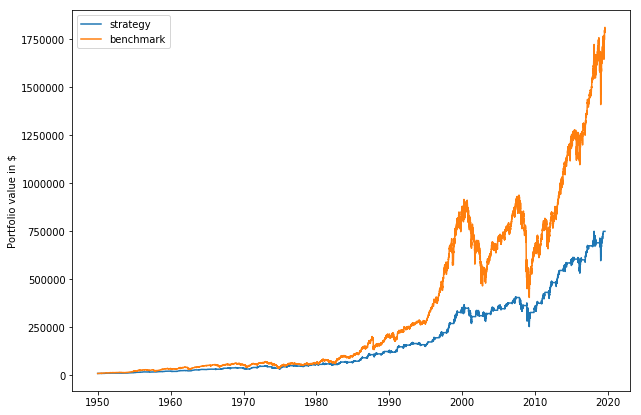

In [11]:
pf.plot_equity_curve(s.dbal, benchmark=benchmark.dbal)

Plot Trades

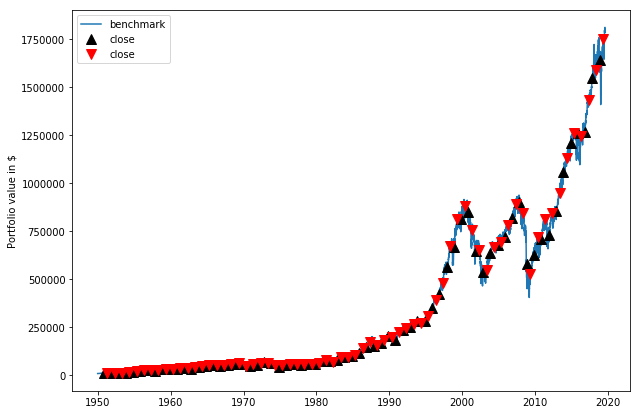

In [12]:
pf.plot_trades(s.dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.40,7.76
max_closed_out_drawdown,-37.89,-56.78
drawdown_annualized_return,-5.92,-7.31
drawdown_recovery,-1.87,-1.42
best_month,23.46,23.49
worst_month,-22.30,-29.56
sharpe_ratio,0.66,0.57
sortino_ratio,0.62,0.73
monthly_std,2.78,4.14


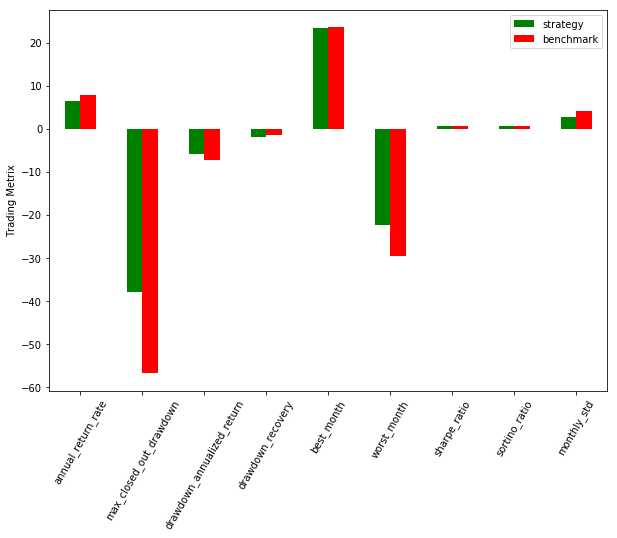

In [13]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')

df = pf.plot_bar_graph(s.stats, benchmark.stats, *metrics)
df